# Importing libraries

In [1]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

# Checking if GPU is detected for Torch

In [2]:
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 3070 Laptop GPU


### The Toeplitz algorithm written in Torch using Torch matmul

In [3]:
def MyConvToepTorch(X, K):
    """
    Intput:
    X - torch.Tensor, image
    K - torch.Tensor, kernel
    Output:
    2D convolution of X and K; type torch.Tensor
    """
    _, _, p, q = K.shape
    _, _, m, n = X.shape
    reshapedX = X.reshape(-1)
    indx = torch.arange(0, (m-p+1)*n, n).reshape(-1,1) + torch.arange(0,n*p)
    B = reshapedX[indx]
    col = torch.nn.functional.pad(K, (0,n-q), mode="constant")
    col = col.reshape((-1,))
    row = torch.zeros(n-q+1)
    row[0] = ker[0,0,0,0]
    vals = torch.cat((col, row[1:]))
    index = torch.arange(0, n-q+1) + torch.unsqueeze(torch.arange(col.shape[0]-1, -1, -1), 1)
    index = torch.flip(index, dims=[0])
    A = vals[index]
    return torch.matmul(B, A)

## The algorithm written with Torch with FFT

In [4]:
m, n = 5, 5
p, q = 3, 3
X = np.random.normal(size=(m, n))
K = np.random.normal(size=(p, q))
im = X.reshape(1, 1, m, n)
ker = K.reshape(1, 1, p, q)
im = torch.tensor(im)
ker = torch.tensor(ker)

In [5]:
def power_of_two(shape):
    if (shape & (shape-1) == 0) and shape != 0:
        return 0
    power = np.int(np.ceil(np.log2(shape)))
    diff = 2**power - shape
    return diff
    
    

In [6]:
def matmult_toeplitz_torch(row, col, v):
    v_row, v_col = v.shape
    mm, nn = row.shape[0], col.shape[0]
    M = nn + mm - 1
    ind_c = torch.arange(M-1, -1,-1) 
    vals = torch.cat((row[1:], col))
    c = vals[ind_c]
    hatv = torch.nn.functional.pad(v, (0,0,0,M-v_row), mode="constant") # padding v with zeros
    FFTv = torch.fft.fft(hatv, axis=0)
    FFTv = torch.transpose(FFTv, 0, 1)
    #FFTv = torch.nn.functional.pad(FFTv, (0,M-v_row), mode="constant") 
    Lambda = torch.fft.fft(c)
    LamFv = torch.multiply(FFTv, Lambda)
    result = torch.fft.ifft(LamFv, axis=1)
    return torch.real(result[:,nn-1:])

In [7]:
def matmult_toeplitz_torch_pow(row, col, v):
    v_row, v_col = v.shape
    mm, nn = row.shape[0], col.shape[0]
    M = nn + mm - 1
    ind_c = torch.arange(M-1, -1,-1) 
    vals = torch.cat((row[1:], col))
    old_c = vals[ind_c]
    C = power_of_two(old_c.shape[0])
    c = torch.nn.functional.pad(vals[ind_c], (0,C), mode="constant") 
    hatv = torch.nn.functional.pad(v, (0,0,0,M-v_row+C), mode="constant") # padding v with zeros
    FFTv = torch.fft.fft(hatv, axis=0)
    FFTv = torch.transpose(FFTv, 0, 1)
    #FFTv = torch.nn.functional.pad(FFTv, (0,M-v_row), mode="constant") 
    Lambda = torch.fft.fft(c)
    LamFv = torch.multiply(FFTv, Lambda)
    result = torch.fft.ifft(LamFv, axis=1)
    return torch.real(result[:,nn-1:-C])

In [8]:
def MyConvToepTorchFFT(X, K):
    """
    Intput:
    X - torch.Tensor, image
    K - torch.Tensor, kernel
    Output:
    2D convolution of X and K; type torch.Tensor
    """
    _, _, p, q = K.shape
    _, _, m, n = X.shape
    reshapedX = X.reshape(-1)
    indx = torch.arange(0, (m-p+1)*n, n).reshape(-1,1) + torch.arange(0,n*p)
    B = torch.transpose(reshapedX[indx], 0, 1)
    col = torch.nn.functional.pad(K, (0,n-q), mode="constant")
    col = col.reshape((-1,))
    row = torch.zeros(n-q+1)
    row[0] = ker[0,0,0,0]
    return matmult_toeplitz_torch(row, col, B)

In [9]:
def MyConvToepTorchFFTpow(X, K):
    """
    Intput:
    X - torch.Tensor, image
    K - torch.Tensor, kernel
    Output:
    2D convolution of X and K; type torch.Tensor
    """
    _, _, p, q = K.shape
    _, _, m, n = X.shape
    reshapedX = X.reshape(-1)
    indx = torch.arange(0, (m-p+1)*n, n).reshape(-1,1) + torch.arange(0,n*p)
    B = torch.transpose(reshapedX[indx], 0, 1)
    col = torch.nn.functional.pad(K, (0,n-q), mode="constant")
    col = col.reshape((-1,))
    row = torch.zeros(n-q+1)
    row[0] = ker[0,0,0,0]
    return matmult_toeplitz_torch_pow(row, col, B)

## Pytorch 2D Conv

In [10]:
def torchconv(x, y):
    """
    Intput:
    X - torch.Tensor, image
    K - torch.Tensor, kernel
    Output:
    2D convolution of X and K; type torch.Tensor
    """
    return torch.nn.functional.conv2d(x, y, padding='valid')

## Testing Outputs

In [11]:
m, n = 7, 7
p, q = 3, 3
X = np.random.normal(size=(m, n))
K = np.random.normal(size=(p, q))

In [12]:
im = X.reshape(1, 1, m, n)
ker = K.reshape(1, 1, p, q)
im = torch.tensor(im)
ker = torch.tensor(ker)
torchconv(im, ker)

tensor([[[[ 1.6108,  2.0071, -1.7883, -1.1185, -2.3272],
          [-1.4261,  1.3871,  0.7290, -2.0031, -0.2715],
          [-0.8562,  0.0827,  2.8352, -0.7330, -0.1146],
          [ 2.3582,  2.5729, -2.2971, -0.2491,  0.5446],
          [-0.2278,  0.2702, -0.4288, -1.5445, -1.1606]]]],
       dtype=torch.float64)

In [13]:
im = X.reshape(1, 1, m, n)
ker = K.reshape(1, 1, p, q)
im = torch.tensor(im)
ker = torch.tensor(ker)
MyConvToepTorch(im, ker)

tensor([[ 1.6108, -2.2662, -1.3558,  0.1773,  1.1582],
        [-1.4261,  0.6708,  0.9173, -3.1703, -2.2187],
        [-0.8562,  0.3243,  0.3929,  0.4709, -1.1729],
        [ 2.3582,  0.4037,  0.1045, -1.1049, -0.5311],
        [-0.2278,  0.6840,  0.4750,  0.3746, -0.6031]], dtype=torch.float64)

In [14]:
im = X.reshape(1, 1, m, n)
ker = K.reshape(1, 1, p, q)
im = torch.tensor(im)
ker = torch.tensor(ker)
MyConvToepTorchFFT(im, ker)

tensor([[ 1.6108,  2.0071, -1.7883, -1.1185, -2.3272],
        [-1.4261,  1.3871,  0.7290, -2.0031, -0.2715],
        [-0.8562,  0.0827,  2.8352, -0.7330, -0.1146],
        [ 2.3582,  2.5729, -2.2971, -0.2491,  0.5446],
        [-0.2278,  0.2702, -0.4288, -1.5445, -1.1606]], dtype=torch.float64)

In [15]:
im = X.reshape(1, 1, m, n)
ker = K.reshape(1, 1, p, q)
im = torch.tensor(im)
ker = torch.tensor(ker)
MyConvToepTorchFFTpow(im, ker)

tensor([[ 1.6108,  2.0071, -1.7883, -1.1185, -2.3272],
        [-1.4261,  1.3871,  0.7290, -2.0031, -0.2715],
        [-0.8562,  0.0827,  2.8352, -0.7330, -0.1146],
        [ 2.3582,  2.5729, -2.2971, -0.2491,  0.5446],
        [-0.2278,  0.2702, -0.4288, -1.5445, -1.1606]], dtype=torch.float64)

## Generating random images

In [16]:
image_size = 100 # image size, square image, 
kernel_size = 20 # kernel size
iterations = 500 # number of images
images = np.random.normal(size=(iterations, image_size, image_size))
kernels = np.random.normal(size=(iterations, kernel_size, kernel_size))
set_of_images = [(x, y) for x, y in zip(images, kernels)]
set_of_images_torch = [
     (torch.tensor(x.reshape(1, 1, image_size, image_size)), torch.tensor(y.reshape(1, 1, kernel_size, kernel_size))) for x, y in set_of_images]

# Benchmark - measuring comp. times

### PyTorch

In [17]:
starttime = timeit.default_timer()
for x in set_of_images_torch: 
    torchconv(*x)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 0.20973254198906943


### My Conv in Pytorch

In [18]:
starttime = timeit.default_timer()
for x in set_of_images_torch: 
    MyConvToepTorch(*x)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 0.2688714739633724


### My Conv in Pytorch FFT

In [19]:
starttime = timeit.default_timer()
for x in set_of_images_torch: 
    MyConvToepTorchFFT(*x)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 0.41088359197601676


In [20]:
starttime = timeit.default_timer()
for x in set_of_images_torch: 
    MyConvToepTorchFFTpow(*x)
print("The time difference is :", timeit.default_timer() - starttime)

The time difference is : 0.6078989210072905


## Long benchmark

In [21]:
def generate_times(
    convfun,
    tensorflow_cond=False,
    cupy_cond=False,
    torch_cond=False,
    trials=10):
    image_size = 100
    iter_size = 100
    time_overall = []
    for kernel_size in tqdm(range(1, image_size), desc="Kernel size"):
        images = np.random.uniform(0, 1, size=(trials, iter_size, image_size, image_size))
        kernels = np.random.normal(size=(trials, iter_size, kernel_size, kernel_size))
        for j in range(trials):
            time_diff_result = []
            set_of_images = []
            for k in range(iter_size):
                X = images[j][k]
                K = kernels[j][k]
                X = torch.tensor(X.reshape(1, 1, image_size, image_size))
                K = torch.tensor(K.reshape(1, 1, kernel_size, kernel_size))
                set_of_images.append([X, K])
            starttime = timeit.default_timer()
            for x in set_of_images: 
                convfun(*x)
            time_diff =  timeit.default_timer() - starttime
            time_diff_result.append(time_diff)
        time_overall.append(time_diff_result)
    return np.array(time_overall).mean(axis=1)

In [22]:
time_conv_torch = generate_times(torchconv, torch_cond=True)

Kernel size: 100%|██████████████████████████████| 99/99 [04:39<00:00,  2.83s/it]


In [23]:
time_conv_toep_torch = generate_times(MyConvToepTorch, torch_cond=True)

Kernel size: 100%|██████████████████████████████| 99/99 [01:04<00:00,  1.54it/s]


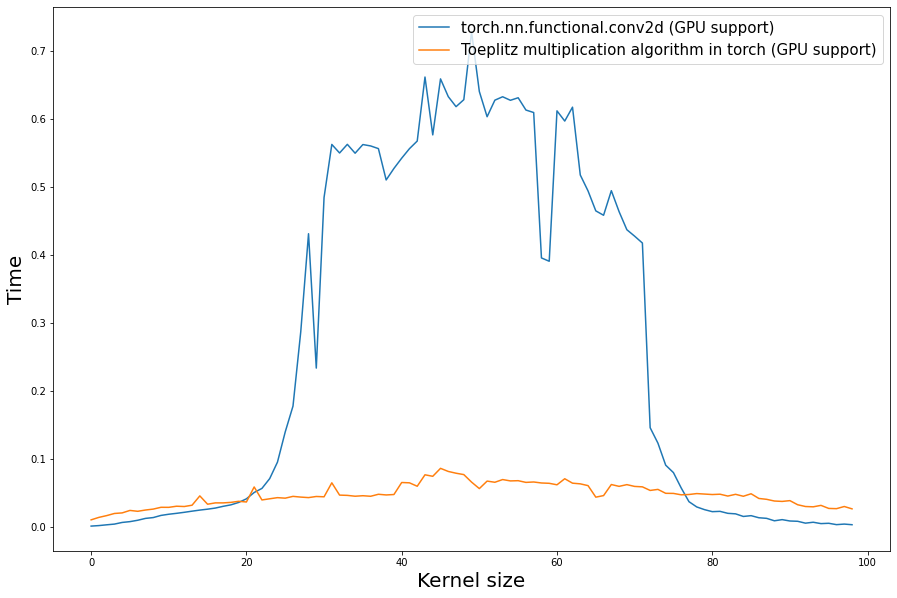

In [25]:
fig = plt.figure(figsize=(15, 10))
plt.plot(time_conv_torch, label="torch.nn.functional.conv2d (GPU support)")
plt.plot(time_conv_toep_torch , label="Toeplitz multiplication algorithm in torch (GPU support)")
plt.plot()
plt.legend(loc="upper right", fontsize=15)
plt.xlabel("Kernel size", fontsize=20)
plt.ylabel("Time", fontsize=20)
fig.savefig("conv2d_torch.jpg")
plt.show()

In [26]:
x = np.arange(10, 100, 5)

In [28]:
y1 = time_conv_torch[x]
y2 = time_conv_toep_torch[x]

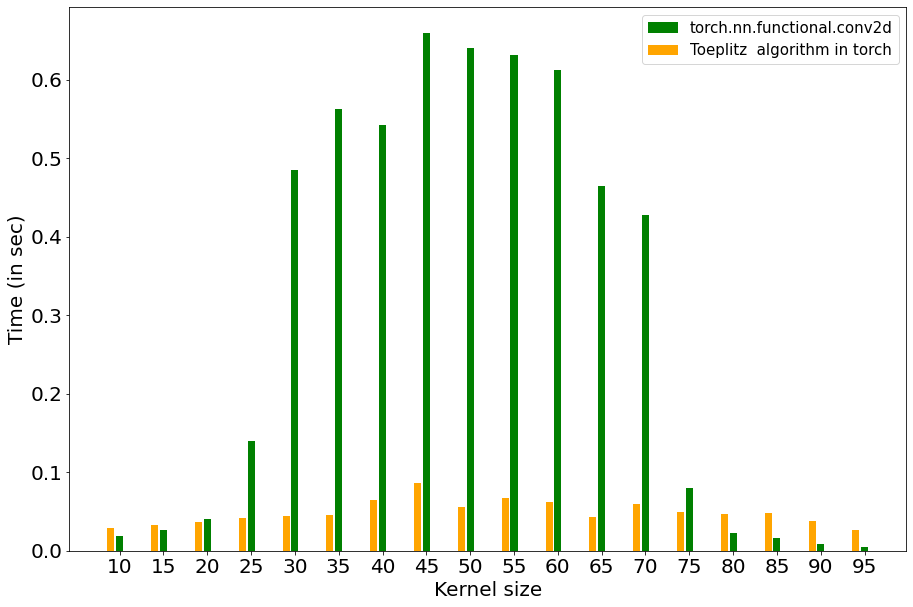

In [30]:
fig = plt.figure(figsize=(15, 10))
plt.bar(x, y1, color="green", label="torch.nn.functional.conv2d")
plt.bar(x-1, y2, color="orange", label="Toeplitz  algorithm in torch")
plt.legend(loc="upper right", fontsize=15)
plt.xlabel("Kernel size", fontsize=20)
plt.xticks(x, fontsize=20)
plt.ylabel("Time (in sec)", fontsize=20)
plt.yticks(fontsize=20)
fig.savefig("conv2d_torch.jpg")
plt.show()